# Suivi de l'apprentissage dans KERAS : sauvegarde automatique du meilleur modèle et mécanisme de "Early Stopping"



Les **callbacks** Keras sont des mécanismes permettant d'intéragir avec l'étape d'apprentissage du modèle. Ils permettent notamment:

1. de stocker les performances mesurées lors de l'apprentissage via le callback "**CSVLogger**"
2. de suivre intéractivement l'évolution de ces performance via le callback "**TensorBoard**"
3. d'implémenter un mécanisme de régularisation basée sur le "**EarlyStopping**" (via le callback du même nom)
4. d'enregistrer automatiquement le meilleur modèle obtenu le long des "epochs" de l'apprentissage, via le callback "**ModelCheckpoint**".

En pratique, on les spécifie lors de l'appel à la fonction "**fit()**" du modèle.



Dans ce notebook nous allons voir comment **mettre en oeuvre les callbacks CSVLogger, ModelCheckpoint et EarlyStopping**.
Nous illustrerons leur intérêt pour **éviter le risque de sur-apprentissage observé lors du TP précédent pour l'apprentissage d'un perception multi-couches** sur les données MNIST.




On commence par charger les packages et par bloquer la graine du générateur aléatoire par souci de reproductibilité. 
**Attention : keras faisant partie de tensorflow depuis la version 2 de tensorflow, les imports ne seront pas les mêmes si vous travaillez à partir de la version 2 ou d'une version antérieure.**
Pour cela, renseigner la variable **"tensorflow_version"** dans la cellule ci-dessous à la valeur **"V1"** ou **"V2"** en fonction de votre configuration.

In [1]:
# specify tensorflow version
tensorflow_version = "V2"

In [2]:
# import packages
import csv
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
# import tensorflow requirements - depending on version
if tensorflow_version == "V1":
    from keras import backend as K
    from keras.models import Model
    from keras.models import Sequential
    from keras.models import load_model
    from keras.layers import Dense, Activation, Flatten
    from keras.layers import Conv2D, MaxPooling2D
    from keras.utils import to_categorical
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import CSVLogger
    from keras.callbacks import EarlyStopping
if tensorflow_version == "V2":
    from tensorflow.keras.models import Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.models import load_model
    from tensorflow.keras.layers import Dense, Activation, Flatten
    from tensorflow.keras.layers import Conv2D, MaxPooling2D
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.callbacks import CSVLogger
    from tensorflow.keras.callbacks import EarlyStopping
# set random seed
np.random.seed(123)

#  Préparation des données

Nous commençons par charger le jeu de données sauvegardé par le premier notebook du TP précédent.

In [3]:
f = open('mnist-dataset.pickle', 'rb')
dataset = pickle.load(f)
f.close()

In [4]:
X_train = dataset[0]
X_test  = dataset[1]
Y_train = dataset[2]
Y_test  = dataset[3]
y_train = dataset[4]
y_test  = dataset[5]

# Réseaux de neurones multicouches & sur-apprentissage

On reproduit ensuite le phénomène de sur-apprentissage observé lors du TP précédent, en apprenant un perceptron multi-couche à deux couches cachées pendant 100 epochs. 

Avant cela, il nous faut néanmoins **transformer les données originales** (des images) pour en avoir une représentation vectorielle, comme on l'a fait pour la régression multinomiale. On commence donc par transformer chaque image de taille 28x28 en un vecteur de taille 784,

In [5]:
input_dim = 28*28 
X_train_vec = X_train.reshape(60000, input_dim) 
X_test_vec  = X_test.reshape(10000, input_dim)

In [6]:
# define multi-layer perceptron with two hidden layers of 64 and 100 neurons to adress the multiclass problem
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_dim=input_dim))
mlp.add(Dense(100, activation='relu'))
mlp.add(Dense(10, activation='softmax'))
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 57,750
Trainable params: 57,750
Non-trainable params: 0
_________________________________________________________________


In [7]:
mlp.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 
history_mlp = mlp.fit(X_train_vec, Y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7748 - accuracy: 0.7995 - val_loss: 0.3579 - val_accuracy: 0.9000
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3411 - accuracy: 0.9020 - val_loss: 0.2872 - val_accuracy: 0.9179
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2868 - accuracy: 0.9170 - val_loss: 0.2601 - val_accuracy: 0.9272
Epoch 4/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2522 - accuracy: 0.9279 - val_loss: 0.2313 - val_accuracy: 0.9353
Epoch 5/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2255 - accuracy: 0.9355 - val_loss: 0.2090 - val_accuracy: 0.9423
Epoch 6/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2050 - accuracy: 0.9413 - val_loss: 0.1929 - val_accuracy: 0.9478
Epoch 7/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1864 - accuracy: 0.9467 - val_loss: 0.1803 - val_ac

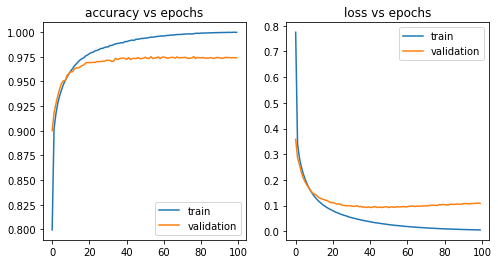

In [8]:
plt.figure(figsize=(8,4))
# show accuracy
plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'], label = 'train')
plt.plot(history_mlp.history['val_accuracy'], label = 'validation')
plt.title("accuracy vs epochs")
plt.legend()
# show loss
plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'], label = 'train')
plt.plot(history_mlp.history['val_loss'], label = 'validation')
plt.title("loss vs epochs")
plt.legend()
plt.show()

# EXERCICE: Implémenter un mécanisme de callback pour stocker automatiquement le meilleur modèle obtenu lors de l'apprentissage. En profiter pour créer un second callback visant à enregistrer les performances mesurées lors de l'apprentissage dans un fichier texte (.csv). 

On utilisera pour cela les callback **ModelCheckPoint** et **CSVLogger**.

**On n'oubliera pas de ré-initialiser le modèle pour que l'apprentissage reprenne depuis le début.**

On ré-initialise le modèle.

In [9]:
# re-create model to re-initialize parmaters 
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_dim=input_dim))
mlp.add(Dense(100, activation='relu'))
mlp.add(Dense(10, activation='softmax'))
mlp.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 

On "re-fitte" le modèle avec 100 epochs en ajoutant des **"callbacks"** pour sauvegarder le meilleur modèle retenu lors de l'apprentissage  et sauvegarder les performances dans un fichier texte.

In [10]:
# define callback to save best model
checkPointModel = ModelCheckpoint('mlp_best-model.h5', monitor = 'val_loss', 
                                  save_best_only = True, save_weights_only = False,
                                  mode = 'auto')
# define callback to save log file
csv_logger = CSVLogger('mlp_training-log.csv')

# fit with callbacks
history_mlp = mlp.fit(X_train_vec, Y_train, batch_size=32, epochs=100, verbose=1, 
                      validation_split=0.2, callbacks = [checkPointModel, csv_logger])

Epoch 1/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7954 - accuracy: 0.7890 - val_loss: 0.3613 - val_accuracy: 0.8992
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3378 - accuracy: 0.9041 - val_loss: 0.2859 - val_accuracy: 0.9178
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2824 - accuracy: 0.9187 - val_loss: 0.2540 - val_accuracy: 0.9272
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2490 - accuracy: 0.9295 - val_loss: 0.2248 - val_accuracy: 0.9356
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2224 - accuracy: 0.9366 - val_loss: 0.2080 - val_accuracy: 0.9413
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2018 - accuracy: 0.9416 - val_loss: 0.1953 - val_accuracy: 0.9440
Epoch 7/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1847 - accuracy: 0.9475 - val_loss: 0.1792 - val_ac

# EXERCICE: Charger le modèle retenu à l'aide de la fonction load_model() et s'en servir pour analyser le jeu de test.

In [11]:
# load model 
best_mlp = load_model('mlp_best-model.h5')

In [12]:
score_mlp = mlp.evaluate(X_test_vec, Y_test, verbose=0)
score_mlp_best = best_mlp.evaluate(X_test_vec, Y_test, verbose=0)
print("multi-layer perceptron test-set accuracy =", score_mlp[1])
print("best multi-layer perceptron test-set accuracy =", score_mlp_best[1])

multi-layer perceptron test-set accuracy = 0.9731000065803528
best multi-layer perceptron test-set accuracy = 0.9735000133514404


# EXERCICE:  Combiner tout cela avec un callback "EarlyStopping". Considérer une "patience" de 5 epochs. Au bout de combien d'epoch l'apprentissage s'arrête t'il ?  

On utilisera pour cela les callback **EarlyStopping**.

**Là aussi, on n'oubliera pas de ré-initialiser le modèle pour que l'apprentissage reprenne depuis le début.**

On ré-initialise le modèle.

In [13]:
# re-create model to re-initialize parmaters 
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_dim=input_dim))
mlp.add(Dense(100, activation='relu'))
mlp.add(Dense(10, activation='softmax'))
mlp.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 

In [14]:
# define callback to save best model
checkPointModel = ModelCheckpoint('mlp-with-early-stopping_best-model.h5', monitor = 'val_loss', 
                                  save_best_only = True, save_weights_only = False,
                                  mode = 'auto')
# define callback to save log file
csv_logger = CSVLogger('mlp-with-early-stopping_training-log.csv')
# define early stoppin callback
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)

# fit with callbacks
history_mlp = mlp.fit(X_train_vec, Y_train, batch_size=32, epochs=100, verbose=1, 
                      validation_split=0.2, callbacks = [checkPointModel, csv_logger, early_stop])

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7852 - accuracy: 0.7891 - val_loss: 0.3552 - val_accuracy: 0.8997
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3381 - accuracy: 0.9031 - val_loss: 0.2865 - val_accuracy: 0.9178
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2831 - accuracy: 0.9184 - val_loss: 0.2504 - val_accuracy: 0.9286
Epoch 4/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2485 - accuracy: 0.9287 - val_loss: 0.2235 - val_accuracy: 0.9365
Epoch 5/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2220 - accuracy: 0.9368 - val_loss: 0.2049 - val_accuracy: 0.9427
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2008 - accuracy: 0.9412 - val_loss: 0.1890 - val_accuracy: 0.9468
Epoch 7/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1836 - accuracy: 0.9461 - val_loss: 0.1796 - val_ac

On représente l'evolution de l'"historique" de l'apprentissage (i.e., l'évolution de l'accuracy et de la loss mesurées sur les données d'apprentissage et de validation) pour mesurer l'impact du "early stopping".

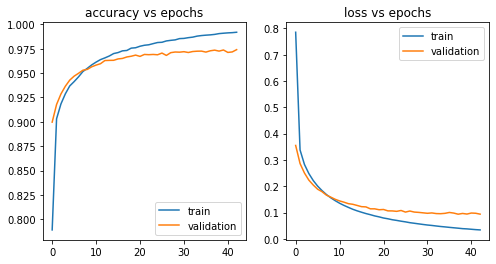

In [15]:
plt.figure(figsize=(8,4))
# show accuracy
plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'], label = 'train')
plt.plot(history_mlp.history['val_accuracy'], label = 'validation')
plt.title("accuracy vs epochs")
plt.legend()
# show loss
plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'], label = 'train')
plt.plot(history_mlp.history['val_loss'], label = 'validation')
plt.title("loss vs epochs")
plt.legend()
plt.show()